<a href="https://colab.research.google.com/github/SINGHAMIT1/Self-Supervised-Contrastive-Learning-/blob/main/self_supervised_contrastive_learning_on_pointcloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Self-Supervised 3D Shape Representation Learning with PyTorch and ShapeNet Dataset

###Developed a self-supervised learning model for 3D shape representation using a subset of the ShapeNet dataset in PyTorch. Implemented DynamicEdgeConv for graph construction and utilized InfoNCE loss for contrastive learning. Successfully separated different entities in the embedding space, demonstrating the model's effectiveness.

---





## Installation / Setup

In [1]:
# using conda for easier installation of PyG
# If only using pip, it somehow takes forever to install on colab 
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [2]:
# Installing torch geometric for point-cloud layers
import torch
version = f"https://data.pyg.org/whl/torch-{torch.__version__}.html"
try: 
    import torch_geometric
except:
    !echo $version
    !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f $version
    import torch_geometric

## Dataset

Goal:
- Self-Supervised Representation Learning of Shapes
- Pointcloud = Set of unconnected nodes --> PyG
- [ShapeNet Dataset](https://paperswithcode.com/dataset/shapenet) - I just use a subset of classes and act like I didn't have labels
- I select 2k data points as otherwise I run out of memory on Colab



In [3]:
from torch_geometric.datasets import ShapeNet
# Limit to 5000 samples, due to RAM restrictions
dataset = ShapeNet(root=".", categories=["Table", "Lamp", "Guitar", "Motorbike"]).shuffle()[:2000]
print("Number of Samples: ", len(dataset))
print("Sample: ", dataset[0])

Extracting ./shapenetcore_partanno_segmentation_benchmark_v0_normal.zip
Processing...
Done!


Number of Samples:  2000
Sample:  Data(x=[2723, 3], y=[2723], pos=[2723, 3], category=[1])


Attribute Name  | Description
-------------------|------------------
Pos       | Normalized positions as 3D coordinates
X       |  Normal vectors 
Y       | Class label 

In [4]:
dataset[1].pos

tensor([[ 0.0218, -0.1359,  0.0021],
        [ 0.0165, -0.3779, -0.0896],
        [-0.0258,  0.3684,  0.0162],
        ...,
        [ 0.0156, -0.2257,  0.0954],
        [-0.0098, -0.3276, -0.1670],
        [-0.0047, -0.3443, -0.1650]])

*USING* plotly to inspect the data 

In [5]:
#!pip install plotly --quiet
import plotly.express as px

def plot_3d_shape(shape):
    print("Number of data points: ", shape.x.shape[0])
    x = shape.pos[:, 0]
    y = shape.pos[:, 1]
    z = shape.pos[:, 2]
    fig = px.scatter_3d(x=x, y=y, z=z, opacity=0.3)
    fig.show()

# Pick a sample
sample_idx = 2
plot_3d_shape(dataset[sample_idx])

Number of data points:  2815


In [6]:
# checkING the distribution of classes
cat_dict = {key: 0 for key in dataset.categories}
for datapoint in dataset: cat_dict[dataset.categories[datapoint.category.int()]]+=1
cat_dict

{'Table': 1375, 'Lamp': 389, 'Guitar': 191, 'Motorbike': 45}

## Data Preparation






In [7]:
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T

data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

augmentation = T.Compose([T.RandomJitter(0.03), T.RandomFlip(1), T.RandomShear(0.2)])

Let's have a look at some samples .

In [8]:
# Original data point
sample = next(iter(data_loader))
plot_3d_shape(sample[2])

Number of data points:  2830


In [9]:
# Augmented data point
transformered = augmentation(sample)
plot_3d_shape(transformered[2])

Number of data points:  2830


## Model

- using implementation of DynamicEdgeConv instead of pointnet
- It uses the parameter k to detect the nearest neighbors which form a subgraph
- In the paper they use 4 layers, here I just have 2






In [10]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import MLP, DynamicEdgeConv, global_max_pool


class Model(torch.nn.Module):
    def __init__(self, k=20, aggr='max'):
        super().__init__()
        # Feature extraction
        self.conv1 = DynamicEdgeConv(MLP([2 * 3, 64, 64]), k, aggr)
        self.conv2 = DynamicEdgeConv(MLP([2 * 64, 128]), k, aggr)
        # Encoder head 
        self.lin1 = Linear(128 + 64, 128)
        # Projection head (See explanation in SimCLRv2)
        self.mlp = MLP([128, 256, 32], norm=None)

    def forward(self, data, train=True):
        if train:
            # Get 2 augmentations of the batch
            augm_1 = augmentation(data)
            augm_2 = augmentation(data)

            # Extract properties
            pos_1, batch_1 = augm_1.pos, augm_1.batch
            pos_2, batch_2 = augm_2.pos, augm_2.batch

            # Get representations for first augmented view
            x1 = self.conv1(pos_1, batch_1)
            x2 = self.conv2(x1, batch_1)
            h_points_1 = self.lin1(torch.cat([x1, x2], dim=1))

            # Get representations for second augmented view
            x1 = self.conv1(pos_2, batch_2)
            x2 = self.conv2(x1, batch_2)
            h_points_2 = self.lin1(torch.cat([x1, x2], dim=1))
            
            # Global representation
            h_1 = global_max_pool(h_points_1, batch_1)
            h_2 = global_max_pool(h_points_2, batch_2)
        else:
            x1 = self.conv1(data.pos, data.batch)
            x2 = self.conv2(x1, data.batch)
            h_points = self.lin1(torch.cat([x1, x2], dim=1))
            return global_max_pool(h_points, data.batch)

        # Transformation for loss function
        compact_h_1 = self.mlp(h_1)
        compact_h_2 = self.mlp(h_2)
        return h_1, h_2, compact_h_1, compact_h_2

## Training

- I use InfoNCE / NT-Xent Loss implemented in pytorch metric learning library
- Temperature allows to balance the similarity measure (make it more peaked)
- Typical values are around 0.1 / 0.2 

In [11]:
# See https://kevinmusgrave.github.io/pytorch-metric-learning/losses/#ntxentloss
!pip install pytorch-metric-learning -q 

from pytorch_metric_learning.losses import NTXentLoss
loss_func = NTXentLoss(temperature=0.10)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.3/109.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 103.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 100.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)


data_loader = DataLoader(dataset, batch_size=32, shuffle=True)


- No test dataset, as the evaluation can be done "downstream"
- The compact representations go into the loss function
- During test time no augmentations are applied and we can use the output representations

In [13]:
import tqdm

def train():
    model.train()
    total_loss = 0
    for _, data in enumerate(tqdm.tqdm(data_loader)):
        data = data.to(device)
        optimizer.zero_grad()
        # Get data representations
        h_1, h_2, compact_h_1, compact_h_2 = model(data)
        # Prepare for loss
        embeddings = torch.cat((compact_h_1, compact_h_2))
        # The same index corresponds to a positive pair
        indices = torch.arange(0, compact_h_1.size(0), device=compact_h_2.device)
        labels = torch.cat((indices, indices))
        loss = loss_func(embeddings, labels)
        loss.backward()
        total_loss += loss.item() * data.num_graphs
        optimizer.step()
    return total_loss / len(dataset)

for epoch in range(1, 5):
    loss = train()
    print(f'Epoch {epoch:03d}, Loss: {loss:.4f}')
    scheduler.step()

100%|██████████| 63/63 [02:26<00:00,  2.32s/it]


Epoch 001, Loss: 1.4655


100%|██████████| 63/63 [02:25<00:00,  2.30s/it]


Epoch 002, Loss: 0.8736


100%|██████████| 63/63 [02:25<00:00,  2.31s/it]


Epoch 003, Loss: 0.6859


100%|██████████| 63/63 [02:25<00:00,  2.31s/it]

Epoch 004, Loss: 0.4962


## Evaluation of the Embeddings

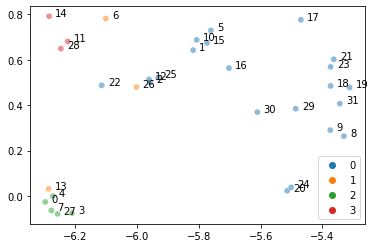

In [14]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Get sample batch
sample = next(iter(data_loader))

# Get representations
h = model(sample.to(device), train=False)
h = h.cpu().detach()
labels = sample.category.cpu().detach().numpy()

# Get low-dimensional t-SNE Embeddings
h_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random').fit_transform(h.numpy())

# Plot
ax = sns.scatterplot(x=h_embedded[:,0], y=h_embedded[:,1], hue=labels, 
                    alpha=0.5, palette="tab10")

# Add labels to be able to identify the data points
annotations = list(range(len(h_embedded[:,0])))

def label_points(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(int(point['val'])))

label_points(pd.Series(h_embedded[:,0]), 
            pd.Series(h_embedded[:,1]), 
            pd.Series(annotations), 
            plt.gca()) 

finding the most similar and most different data points.



In [15]:
import numpy as np

def sim_matrix(a, b, eps=1e-8):
    """
    Eps for numerical stability
    """
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    return sim_mt

similarity = sim_matrix(h, h)
max_indices = torch.topk(similarity, k=2)[1][:, 1]
max_vals  = torch.topk(similarity, k=2)[0][:, 1]

# Select index
idx = 17
similar_idx = max_indices[idx]
print(f"Most similar data point in the embedding space for {idx} is {similar_idx}")

Most similar data point in the embedding space for 17 is 18


Categories are: "Table", "Lamp", "Guitar", "Motorbike", "Skateboard"

This is only based on the data in the current batch!

In [16]:
plot_3d_shape(sample[idx].cpu())

Number of data points:  2791


In [17]:
plot_3d_shape(sample[similar_idx].cpu())

Number of data points:  2721


This confirms that our embedding space has a proper arrangement and that our contrastive loss separated different entities successfully.